In [33]:
!pip install spacy
!python -m spacy download en_core_web_sm
!pip install -U scikit-learn

     |████████████████████████████████| 12.8 MB 9.3 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     |████████████████████████████████| 9.6 MB 14.4 MB/s eta 0:00:01
     |████████████████████████████████| 297 kB 82.8 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.0.1
    Uninstalling joblib-1.0.1:
      Successfully uninstalled joblib-1.0.1
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2


In [34]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict 
import spacy
import en_core_web_sm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
from collections import Counter 

In [35]:
raw = pd.read_csv('ted_talks_en.csv')
#raw

In [36]:
arr = raw['topics'].to_numpy()
keywords = defaultdict(int)
for i, inner in enumerate(arr):
    x = inner.split("'")
    for i, tag in enumerate(x):
        if i % 2 != 0 and i != 0 and i != len(x) - 1:
            keywords[tag.lower()] += 1

In [37]:
most_common_keywords = sorted(list(keywords.keys()), key=lambda keyword: keywords[keyword])[::-1]
occurences = [keywords[keyword] for keyword in most_common_keywords]
#list(zip(most_common_keywords, occurences))

(array([380.,  39.,  16.,  10.,   4.,   6.,   1.,   0.,   0.,   2.]),
 array([  1., 100., 199., 298., 397., 496., 595., 694., 793., 892., 991.]),
 <BarContainer object of 10 artists>)

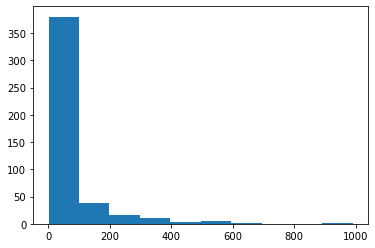

In [38]:
plt.hist(occurences)

In [39]:
cutoff = 80
y = filter(lambda x: x >= cutoff, occurences)
print(f"Amount of topics with occurences >= 80 : {len(list(y))}")

Amount of topics with occurences >= 80 : 103


In [40]:
def convert_topics(topic):
    x = topic.split("'")
    tags = []
    for i, tag in enumerate(x):
        if i % 2 != 0 and i != 0 and i != len(x) - 1:
            tags.append(tag.lower())
    return tags

def correct_dataframe_topics_column(df, in_place=False):
    if not in_place:
        df = df.copy()
    topics_listed_column = df['topics'].apply(convert_topics)
    df['topics'] = topics_listed_column
    return df

corrected_topics = correct_dataframe_topics_column(raw)
#corrected_topics

In [41]:
"""
Topics of focus:
STEM - Science, Technology, Engineering, Math(Mathematics), Psychology, Physics, Biotech, AI, Cognitive Science
Culture - Culture, Society, Community
Business - Business, Economics
Social Change - social change/activism
History - History/Politics
"""
topic_to_group = defaultdict(lambda: 'not-relevant')
stem = ["science", "technology", "engineering", "math", "mathematics", "psychology", "physics", "biotech", "ai", "cognitive science"]
culture = ["culture", "society", "community"]
business = ["business", "economics"]
activism = ['social change', 'activism']
history = ['history', 'politics']
categories = [ ['stem'] + stem, ['culture'] + culture, ['business'] + business,
              ['activism'] + activism, ['history'] + history]

for category in categories:
    cat = None
    for i, topic in enumerate(category):
        if i == 0:
            cat = topic
            continue
        topic_to_group[topic] = cat

In [42]:
def group_topics(topic_list):
    grouped = set()
    for topic in topic_list:
        grouped.add(topic_to_group[topic])
    if len(grouped) > 1 and 'not-relevant' in grouped:
        grouped.remove('not-relevant')
    return grouped

def group_df_topics(df, in_place=False):
    if not in_place:
        df = df.copy()
    df['topics'] = df['topics'].apply(group_topics)
    return df

grouped_topics = group_df_topics(corrected_topics)
#grouped_topics

In [43]:
def count_unique_words(script): 
    unique_words = dict()
    script_lst = script.split()
    for word in script_lst: 
        if word in unique_words: 
            unique_words[word] += 1
        else: 
            unique_words[word] = 1
    return unique_words

def add_words(df, in_place=False):
    if in_place:
        df = df.copy()
    df["clean_scripts"] = (
    df["transcript"]
    .str.replace(r'\(Music: [^)]+\) ','', regex = True)
    .str.replace(r' — ', ' ', regex = True)
    .str.replace(r'[[."\'!\],:?;=+*&]', '', regex = True)
    .str.lower())
    df["words"] = df["clean_scripts"].apply(count_unique_words)
    return df

In [44]:
def one_hot_encode(df: pd.DataFrame, verbose=False, in_place=False):
    """
    expects df to have a columns ['words'] which contains a dictionary for each entry,
    this dictionary has all the unique words in this row's transcript as keys, and their values
    correspond the amount of time that word appears in the transcript. This creates 
    """
    word_dicts = df['words'].to_numpy()
    total_dict = defaultdict(int)
    total_count = 0
    for word_dict in word_dicts:
        for word in word_dict.keys():
            total_dict[word] += word_dict[word]
            total_count += word_dict[word]
    unique_count = len(list(total_dict.keys()))
    if verbose: 
        print("Amount of unique words: {:,}".format(unique_count), 
             "\nTotal word count: {:,}".format(total_count))
    
    word_to_onehot_location = {}
    for i, word in enumerate(list(total_dict.keys())):
        word_to_onehot_location[word] = i
        
    new_col = []
    for i, row in enumerate(word_dicts):
        new_entry = np.zeros(unique_count, dtype=int)
        for word in row:
            new_entry[word_to_onehot_location[word]] = 1
        new_col.append(new_entry)
    if in_place:
        new_df = df
    else:
        new_df = df.copy()
    new_df['one-hot'] = new_col
    return new_df

def sentence_type(df, in_place=False):
    """
    adds an array to each row
    this array contains the frequency of each setence type
    arr[0] = . | arr[1] = ? | arr[2] = !
    each entry is total occurences / total punctuation count
    """
    new_col = []
    for transcript in df['transcript']:
        new_entry = np.zeros(3)
        total_sentences = transcript.count('.') + transcript.count('?') + transcript.count('!') + 1
        new_entry[0] = (transcript.count('.') + 1)/ total_sentences
        new_entry[1] = (transcript.count('?') + 1)/ total_sentences
        new_entry[2] = (transcript.count('!') + 1)/ total_sentences
        new_col.append(new_entry)
    if in_place:
        new_df = df
    else:
        new_df = df.copy()
    new_df['sentence-type'] = new_col
    return new_df


In [49]:
## TFIDF Calculation
def tfidf_value(transcript):
    tfIdfVectorizer = TfidfVectorizer(use_idf=True)
    tfIdf = tfIdfVectorizer.fit_transform([transcript])
    #list_of_words_tfidf = tfIdfVectorizer.get_feature_names_out()
    tfidf_value = tfIdf.toarray()[0]
    return tfidf_value
def tfidf_words(transcript):
    tfIdfVectorizer = TfidfVectorizer(use_idf=True)
    tfIdf = tfIdfVectorizer.fit_transform([transcript])
    list_of_words_tfidf = tfIdfVectorizer.get_feature_names()
    tfidf_words = list_of_words_tfidf
    return tfidf_words
def tfidf_dict(transcript):
    tfIdfVectorizer = TfidfVectorizer(use_idf=True)
    tfIdf = tfIdfVectorizer.fit_transform([transcript])
    list_of_words_tfidf = tfIdfVectorizer.get_feature_names()
    tfidf_value = tfIdf.toarray()[0]
    tfidf_dict = dict(zip(list_of_words_tfidf,tfidf_value))
    return tfidf_dict

def add_tfidf(df: pd.DataFrame, in_place=False):
    if in_place:
        df = df.copy()
    df['tfidf'] = df['transcript'].apply(tfidf_value)
    df['tfidf_word'] = df['transcript'].apply(tfidf_words)
    df['tfidf_dict'] = df['transcript'].apply(tfidf_dict)
    return df

In [50]:
data = raw.copy()
data = group_df_topics(data, in_place=True)
data = add_words(data, in_place=True)
data = one_hot_encode(data, in_place=True)
data = sentence_type(data, in_place=True)
data = add_tfidf(data, in_place=True)

In [51]:
data

,talk_id,title,speaker_1,all_speakers,occupations,about_speakers,views,recorded_date,published_date,event,...,url,description,transcript,clean_scripts,words,one-hot,sentence-type,tfidf,tfidf_word,tfidf_dict
0,1,Averting the climate crisis,Al Gore,{0: 'Al Gore'},{0: ['climate advocate']},{0: 'Nobel Laureate Al Gore focused the world’...,3523392,2006-02-25,2006-06-27,TED2006,...,https://www.ted.com/talks/al_gore_averting_the...,With the same humor and humanity he exuded in ...,"Thank you so much, Chris. And it's truly a gre...",thank you so much chris and its truly a great ...,"{'thank': 3, 'you': 39, 'so': 5, 'much': 9, 'c...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.9096774193548387, 0.05806451612903226, 0.04...","[0.004944137818219958, 0.004944137818219958, 0...","[238, 28, 30, 31, 39, 40, 50, about, accomplis...","{'238': 0.004944137818219958, '28': 0.00494413..."
1,92,The best stats you've ever seen,Hans Rosling,{0: 'Hans Rosling'},{0: ['global health expert; data visionary']},"{0: 'In Hans Rosling’s hands, data sings. Glob...",14501685,2006-02-22,2006-06-27,TED2006,...,https://www.ted.com/talks/hans_rosling_the_bes...,You've never seen data presented like this. Wi...,"About 10 years ago, I took on the task to teac...",about 10 years ago i took on the task to teach...,"{'about': 15, '10': 3, 'years': 9, 'ago': 1, '...","[1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, ...","[0.9116465863453815, 0.09236947791164658, 0.00...","[0.0029276458487846966, 0.00878293754635409, 0...","[000, 10, 100, 1960, 1962, 1964, 1970, 1974, 2...","{'000': 0.0029276458487846966, '10': 0.0087829..."
2,7,Simplicity sells,David Pogue,{0: 'David Pogue'},{0: ['technology columnist']},{0: 'David Pogue is the personal technology co...,1920832,2006-02-24,2006-06-27,TED2006,...,https://www.ted.com/talks/david_pogue_simplici...,New York Times columnist David Pogue takes aim...,"(Music: ""The Sound of Silence,"" Simon & Garfun...",hello voice mail my old friend (laughter) ive ...,"{'hello': 1, 'voice': 3, 'mail': 2, 'my': 17, ...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, ...","[0.8561872909698997, 0.12040133779264214, 0.03...","[0.003229757844257144, 0.003229757844257144, 0...","[000, 10, 11, 12, 18, 1982, 1997, 20, 200, 200...","{'000': 0.003229757844257144, '10': 0.00322975..."
3,53,Greening the ghetto,Majora Carter,{0: 'Majora Carter'},{0: ['activist for environmental justice']},{0: 'Majora Carter redefined the field of envi...,2664069,2006-02-26,2006-06-27,TED2006,...,https://www.ted.com/talks/majora_carter_greeni...,"In an emotionally charged talk, MacArthur-winn...",If you're here today — and I'm very happy that...,if youre here today and im very happy that you...,"{'if': 6, 'youre': 3, 'here': 6, 'today': 3, '...","[1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, ...","[0.9187817258883249, 0.06598984771573604, 0.02...","[0.015522192347839546, 0.007761096173919773, 0...","[000, 10, 1960s, 1990s, 1998, 20, 25, 27, 28, ...","{'000': 0.015522192347839546, '10': 0.00776109..."
4,66,Do schools kill creativity?,Sir Ken Robinson,{0: 'Sir Ken Robinson'},"{0: ['author', 'educator']}","{0: ""Creativity expert Sir Ken Robinson challe...",65051954,2006-02-25,2006-06-27,TED2006,...,https://www.ted.com/talks/sir_ken_robinson_do_...,Sir Ken Robinson makes an entertaining and pro...,Good morning. How are you? (Audience) Good. It...,good morning how are you (audience) good its b...,"{'good': 4, 'morning': 1, 'how': 7, 'are': 19,...","[1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, ...","[0.8489208633093526, 0.14388489208633093, 0.01...","[0.0033326113457486047, 0.0066652226914972095,...","[15, 16, 1930s, 19th, 20, 2065, 21, 30, 30s, 5...","{'15': 0.0033326113457486047, '16': 0.00666522..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4000,62678,"Crisis support for the world, one text away",Nancy Lublin,{0: 'Nancy Lublin'},{0: ['health activist']},"{0: 'Nancy Lublin, cofounder and CEO of Crisis...",502934,2020-04

In [ ]:
nlp = en_core_web_sm.load()

In [16]:
doc = nlp(grouped_topics.iloc[0].transcript)

In [72]:
doc

array([[-1.4706371 ,  0.21765131, -1.0314393 , ...,  1.4120553 ,
        -0.944253  ,  0.50613815],
       [-0.16434939,  0.82951665, -0.6400423 , ..., -0.08375989,
        -0.1077116 , -0.34314856],
       [ 1.3233514 , -0.01322406,  0.2967692 , ...,  1.2514224 ,
        -1.7730263 , -0.17876387],
       ...,
       [-0.20854652, -1.1892142 , -0.16210335, ..., -0.37219468,
        -0.31842452,  0.71036816],
       [-0.76609504, -0.22358406, -1.0391988 , ..., -0.0962096 ,
         1.8497169 ,  1.5730871 ],
       [-1.1381158 , -0.25188053, -0.5198487 , ..., -0.23793721,
         0.19479394, -1.4996935 ]], dtype=float32)

In [23]:
str.remove

Object `str.remove` not found.
